In [1]:
import sys
sys.path.append("/home/jaxmao/jaxmaov2_/JaxMao/")

In [2]:
import pickle, cv2
from sklearn.utils import shuffle

def load_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def load_GTSRB(color='rgb'):
    if not color in ['rgb', 'hsv']:
        return False
    X_train = load_pickle_file('/home/jaxmao/jaxmao/dataset/GTSRB_hsv/X_train.pkl')
    y_train = load_pickle_file('/home/jaxmao/jaxmao/dataset/GTSRB_hsv/y_train.pkl')
    X_test = load_pickle_file('/home/jaxmao/jaxmao/dataset/GTSRB_hsv/X_test.pkl')
    y_test = load_pickle_file('/home/jaxmao/jaxmao/dataset/GTSRB_hsv/y_test.pkl')

    if color == 'rgb':
        for i in range(len(X_train)):
            X_train[i] = cv2.cvtColor(X_train[i].astype('float32'), cv2.COLOR_HSV2RGB)
        for i in range(len(X_test)):
            X_test[i] = cv2.cvtColor(X_test[i].astype('float32'), cv2.COLOR_HSV2RGB)
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_GTSRB(color='rgb')

In [3]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

# Build and train the model

start by importing neccessary layers, loss, optimizer, and initializer(optional) <br>
initiate jax random key with seed=24

In [4]:
from jaxmao import Module, Bind, Conv2d, BatchNorm2d, GlobalAveragePooling2d, MaxPooling2d
from jaxmao import regularizers as regul
from jaxmao import optimizers as optim
from jaxmao import losses
from jaxmao import initializers as init
import jax

key = jax.random.key(24)

I0000 00:00:1703933997.543111  528505 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [5]:

from jaxmao.nn.modules import DropBlock

define helper class `ConvBNRelu` and the main model `Classifier`

In [6]:
max_pool2d = MaxPooling2d(strides=(1,1))

class ConvBnRelu(Module):
    def __init__(self, in_channels, out_channels, activation=None, strides=1, kernel_size=3):
        super().__init__()
        self.conv = Conv2d(in_channels, out_channels, kernel_size=kernel_size, strides=strides, padding='valid', use_bias=False, kernel_init=init.GlorotUniform())
        self.bn = BatchNorm2d(out_channels)
        self.activation = activation
    
    def call(self, inputs):
        x = self.bn(self.conv(inputs))
        return self.activation(x) if self.activation else x

class Classifier(Module):
    def __init__(self):
        super().__init__()
        self.bn0 = BatchNorm2d(3)
        self.conv1 = ConvBnRelu(3, 32, jax.nn.relu, 2)
        self.conv2 = ConvBnRelu(32, 32, jax.nn.relu, 1)
        self.conv3 = ConvBnRelu(32, 64, jax.nn.relu, 2)
        self.conv4 = ConvBnRelu(64, 64, jax.nn.relu, 1)
        
        self.db2 = DropBlock(2, 0.05)
        self.conv_expand = ConvBnRelu(64, 512, jax.nn.relu, 1, 1)
        self.conv_out = ConvBnRelu(512, 43, None, strides=1, kernel_size=1)
        self.gap = GlobalAveragePooling2d()
        
    def call(self, x):
        x = self.bn0(x)
        x = self.db2(x)
        x = self.db2(self.conv2(self.conv1(x)))
        x = (self.conv4(self.db2(self.conv3(x))))
        return jax.nn.softmax(self.gap(self.conv_out(self.conv_expand(x))))

initialize parameters and states.

In [7]:
clf = Classifier()
params, states = clf.init(key)

/home/jaxmao/jaxmaov2_/JaxMao/jaxmao/nn/modules.py:508: UserWarning: DropBlock seed is not provided. Proceed with default seed. Be careful with randomness.
  warnings.warn('DropBlock seed is not provided. Proceed with default seed. Be careful with randomness.')


define training step

In [8]:
optimizer = optim.Adam(params, lr=1e-2)
cce_loss = losses.CategoricalCrossEntropy(eps=1e-6)

@jax.jit
def train_step(params, states, optim_state, X, y):
    def apply_loss(params, states, X, y):
        prediction, states, reg = clf.apply(X, params, states)
        return cce_loss(prediction, y) + reg, states
    (loss_value, states), gradients = jax.value_and_grad(apply_loss, argnums=0, has_aux=True)(params, states, X, y)
    params, optim_state = optimizer.step(params, gradients, optim_state)
    return loss_value, params, states, optim_state

training loop

In [9]:
EPOCHS = 10
BATCH_SIZE = 128
BATCH_NUMS = len(X_train) // BATCH_SIZE

for epoch in range(EPOCHS):
    toltal_losses = 0.0
    for batch_idx in range(BATCH_NUMS):
        starting_idx = batch_idx*BATCH_SIZE
        ending_idx= (batch_idx+1)*BATCH_SIZE
        loss_value, params, states, optimizer.states = train_step(params, states, optimizer.states, X_train[starting_idx:ending_idx], y_train[starting_idx:ending_idx])
        toltal_losses += loss_value
    loss = toltal_losses / BATCH_NUMS
    print(f"{epoch} loss: {loss}")

0 loss: 2.173471450805664
1 loss: 0.3735125958919525
2 loss: 0.12625287473201752
3 loss: 0.07015813887119293
4 loss: 0.047665126621723175
5 loss: 0.0402357317507267
6 loss: 0.02954128384590149
7 loss: 0.023900870233774185
8 loss: 0.02124200202524662
9 loss: 0.01811971142888069


In [10]:
from sklearn.metrics import accuracy_score

with Bind(clf, params, states) as ctx:
    predictions = ctx.module(X_test)
    predictions_cls = predictions.argmax(axis=1)
    accuracy = accuracy_score(y_test.argmax(axis=1), predictions_cls)
accuracy

0.9660339660339661

17
17


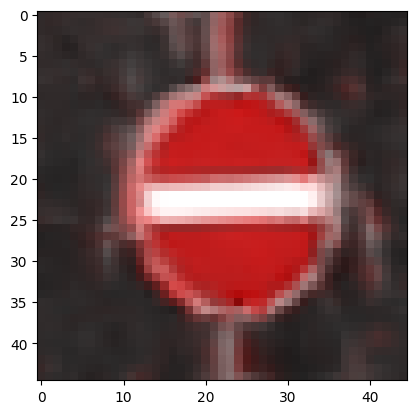

In [11]:
import matplotlib.pyplot as plt

plt.imshow(X_test[0])
print(y_test[0].argmax())
print(predictions_cls[0])
plt.show()